In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision as tv
from more_itertools import first
from PIL import Image
from pytorch_lightning import Trainer
from torch.nn import functional as F
from torchvision.utils import make_grid

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from dhdrnet.data_module import HDRDataModule
from dhdrnet.histogram_model import HistogramNet
from dhdrnet.model import (
    DHDRMobileNet_v1,
    DHDRMobileNet_v2,
    DHDRMobileNet_v3,
    DHDRSimple,
    DHDRSqueezeNet,
)
from dhdrnet.resnet_model import DHDRResnet
from dhdrnet.util import DATA_DIR, ROOT_DIR

outdir = ROOT_DIR / "precomputed_data"
figdir = outdir / "figures"
plt.rcParams["figure.figsize"] = (10, 10)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
gpus = "0" if torch.cuda.is_available() else None


def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation="nearest")
    plt.show()

In [3]:
from IPython.utils import io


def get_best_model(model_cls, backbone: str):
    with io.capture_output(stdout=True, stderr=True) as _captured:
        trainer = Trainer(gpus=gpus)  # progress_bar_refresh_rate=0)
        best_score = 1e10
        best_model = None
        for ckpt in (ROOT_DIR / "checkpoints").glob(f"*{backbone}*"):
            model = model_cls.load_from_checkpoint(checkpoint_path=str(ckpt))
            model.eval()

            test_score = first(trainer.test(model, datamodule=HDRDataModule()))[
                "test_loss"
            ]
            print(test_score)
            if test_score < best_score:
                best_score = test_score
                best_model = model

    print(best_score)
    return best_model, best_score

In [4]:
resnet_score, resnet_model = get_best_model(DHDRResnet, "resnet")

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


1.5792813301086426


In [5]:
# best_hist, hist_scores = get_best_model(HistogramNet, "hist")

In [6]:
best_mobilev1, mobile_v1_scores = get_best_model(DHDRMobileNet_v1, "mobile_v1")

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


1.5918484926223755


In [7]:
best_mobilev2, mobile_v2_scores = get_best_model(DHDRMobileNet_v2, "mobile_v2")

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


1.2508515119552612


In [8]:
best_mobilev3, mobile_v3_scores = get_best_model(DHDRMobileNet_v3, "mobile_v3")

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


1.5381098985671997


In [9]:
best_squeeze, squeeze_scores = get_best_model(DHDRSqueezeNet, "squeeze")

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


1.7230786085128784


In [11]:
best_model = best_mobilev3

In [12]:
image_names = pd.read_csv(outdir / "test_current.csv", header=None).sample(n=9)[0]

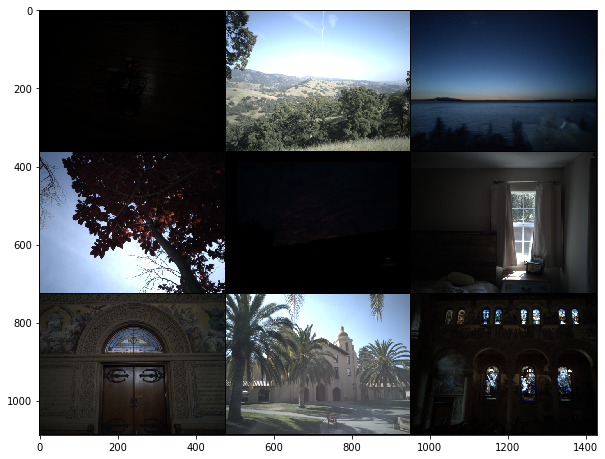

In [13]:
input_images = [
    Image.open(DATA_DIR / "exposures" / f"{name}[0.0].png") for name in image_names
]

transforms = tv.transforms.Compose(
    [
        tv.transforms.CenterCrop((360, 474)),  # min dimensions along DS
        tv.transforms.ToTensor(),
    ]
)
image_tensors = torch.stack([transforms(im) for im in input_images])
show(make_grid(image_tensors, nrow=3))

In [14]:
ev_options = np.arange(-3, 6.25, 0.25)


def get_preds(model, input):
    outputs = F.softmax(model(input.to(device)), dim=1)
    _, predictions = torch.max(outputs, 1)
    predictions = predictions.to("cpu")
    return predictions


predictions = get_preds(best_model, image_tensors)
print(f"{predictions=}")

predictions=tensor([30,  8, 26, 27, 29, 26, 26, 23, 28])


/home/shane/.cache/pypoetry/virtualenvs/dhdrnet-md5k9ngR-py3.8/lib/python3.8/site-packages/colour/utilities/verbose.py:237: ColourWarning: "Adobe DNG Converter" is not available on your platform!
  warn(*args, **kwargs)


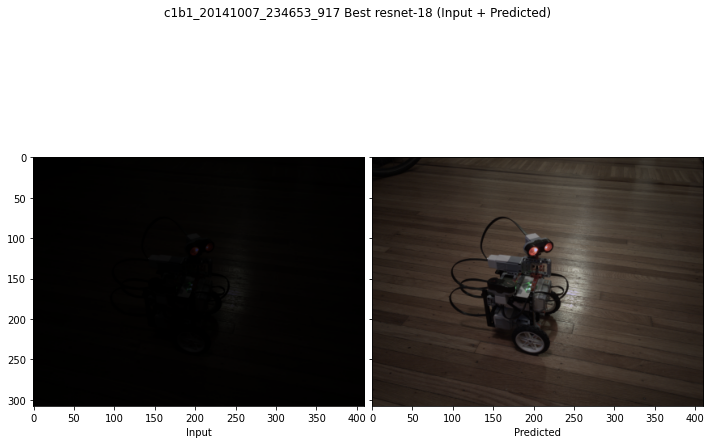

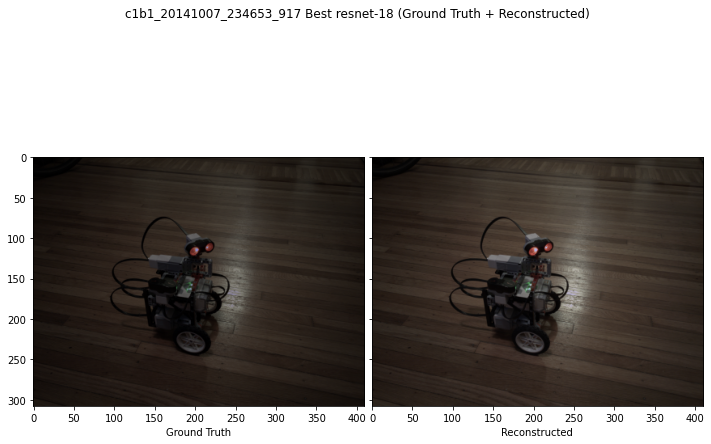

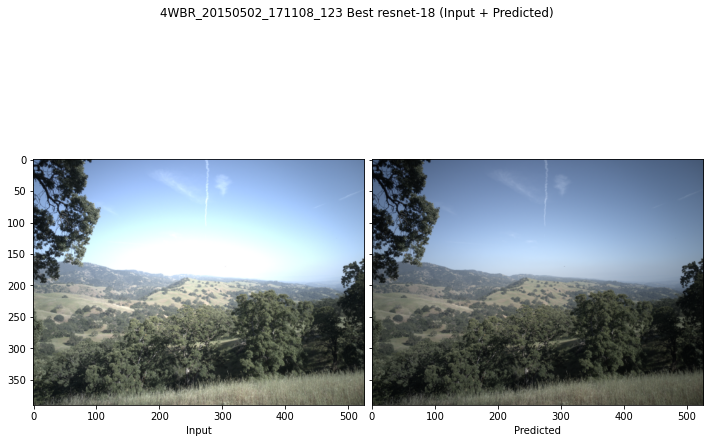

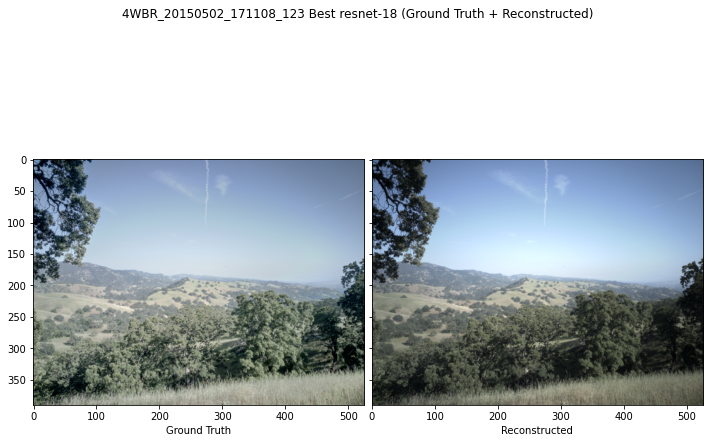

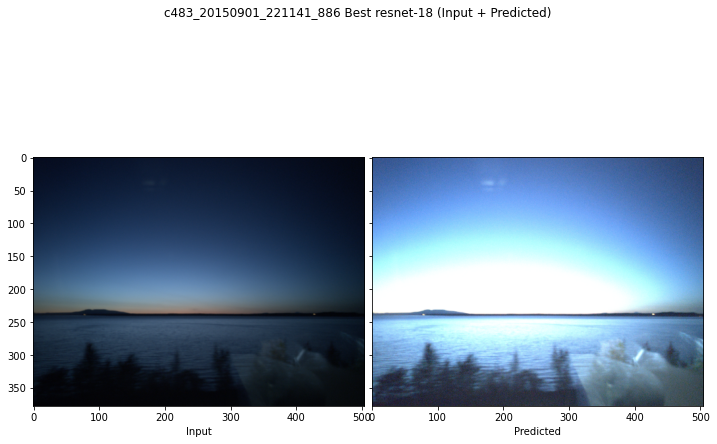

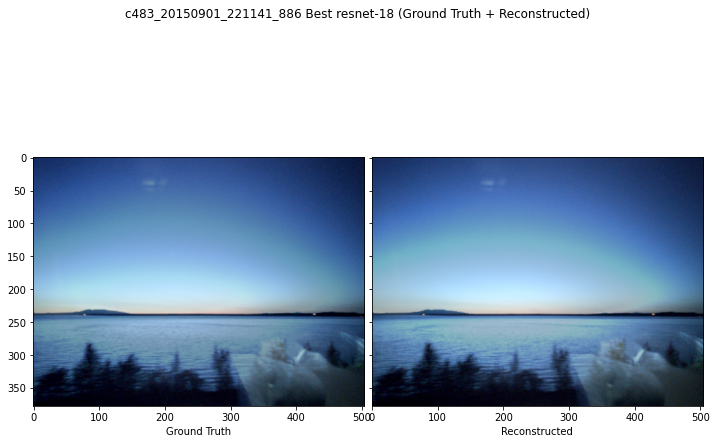

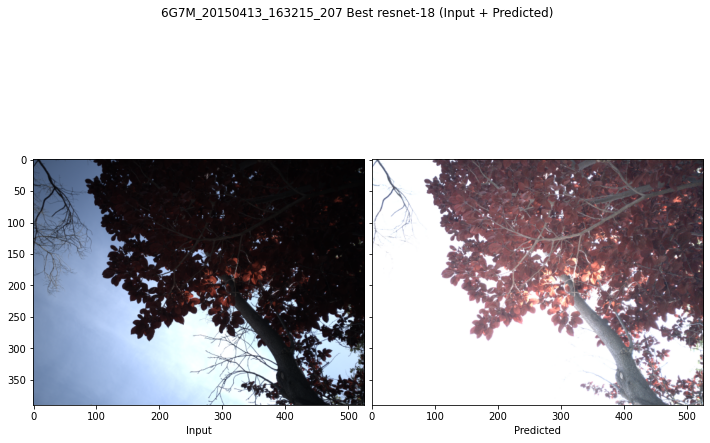

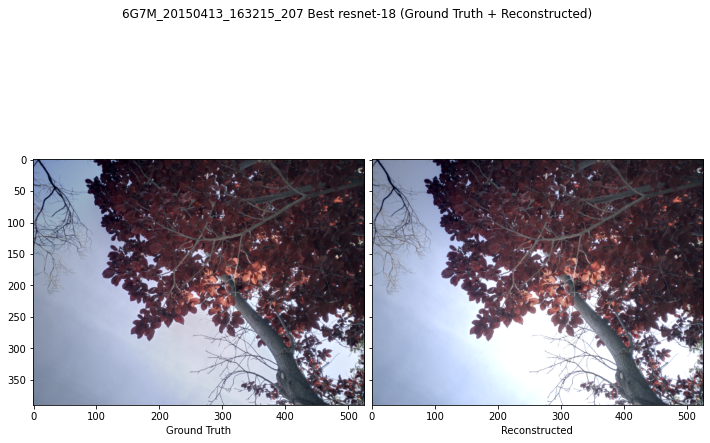

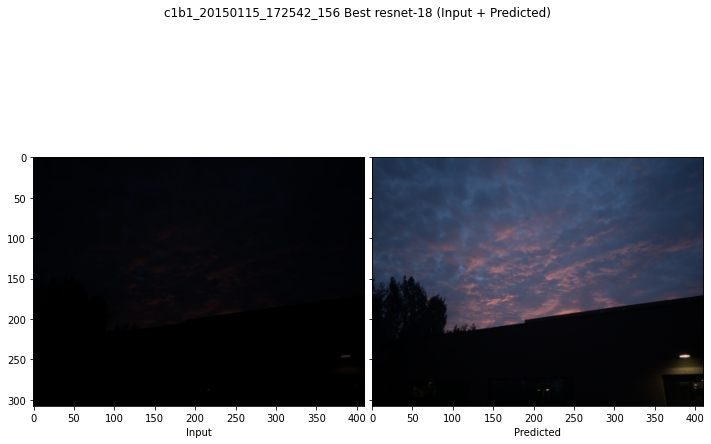

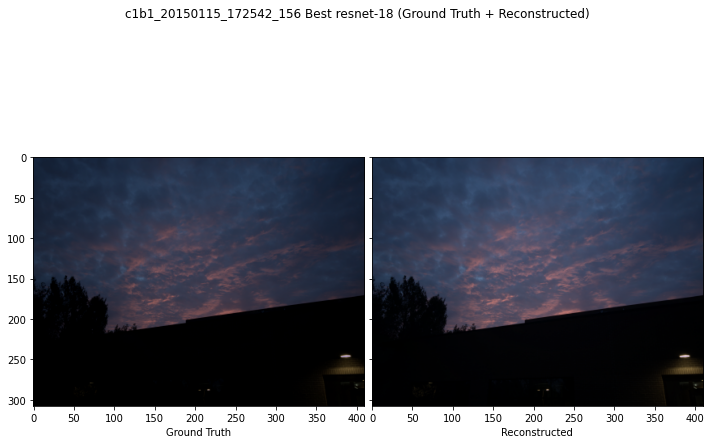

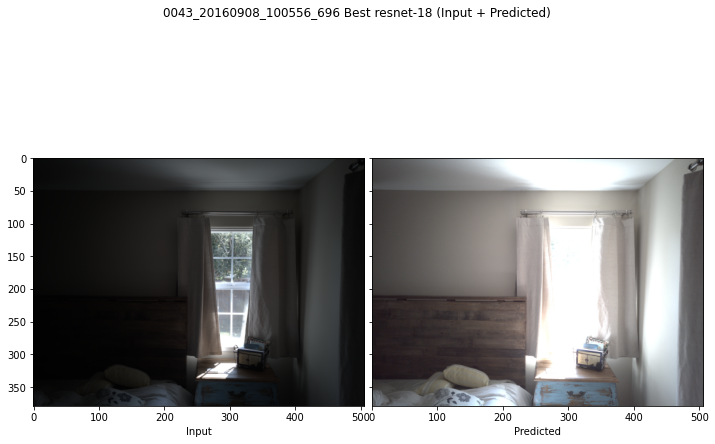

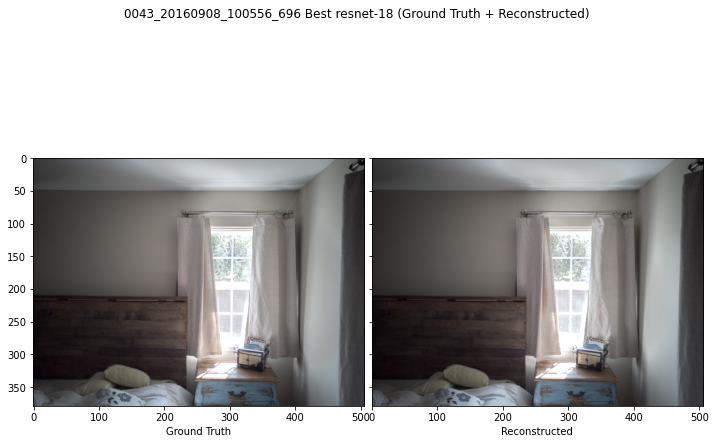

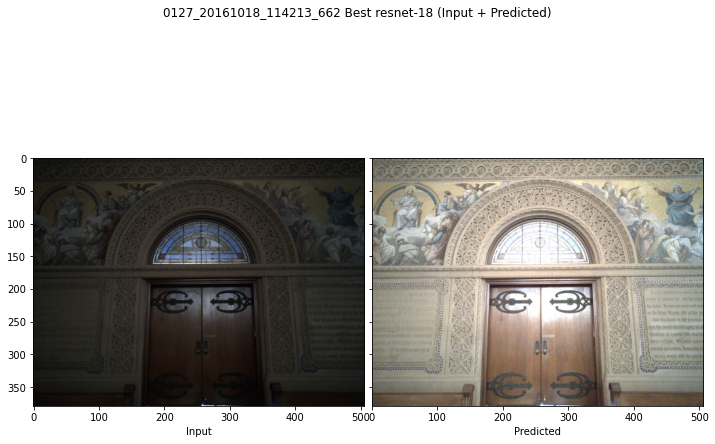

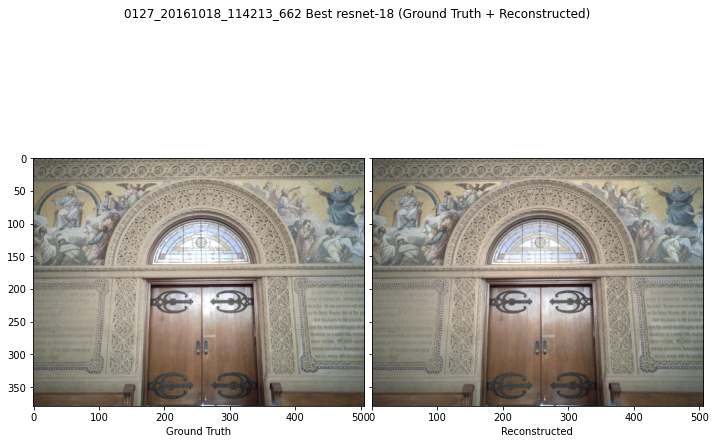

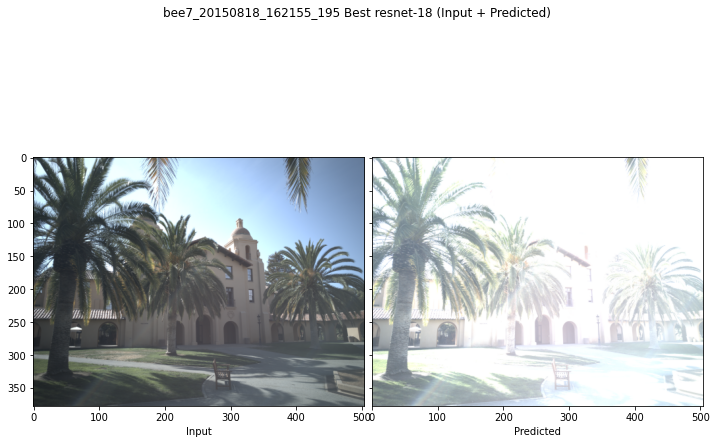

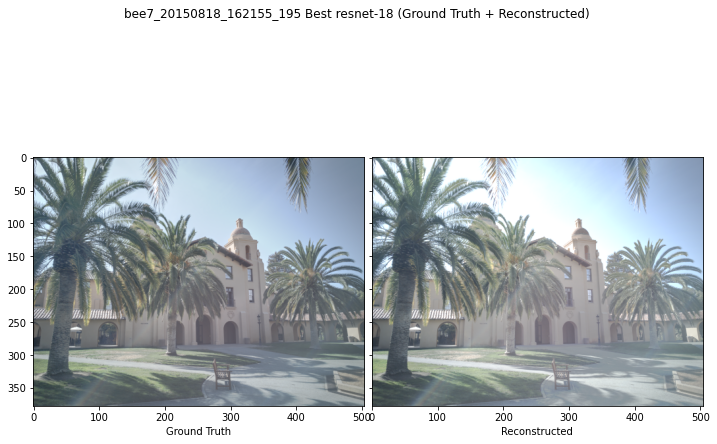

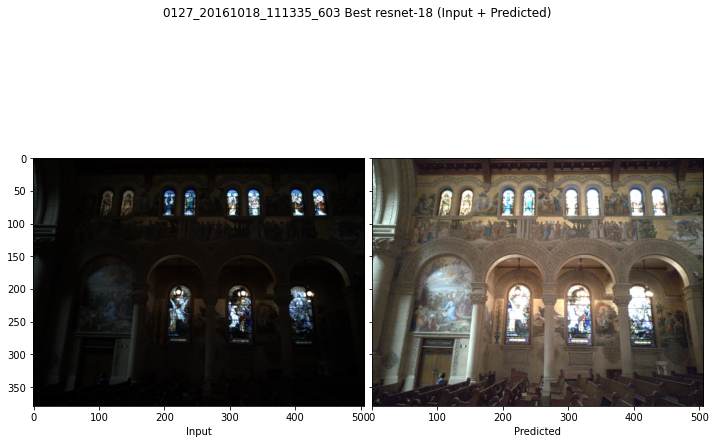

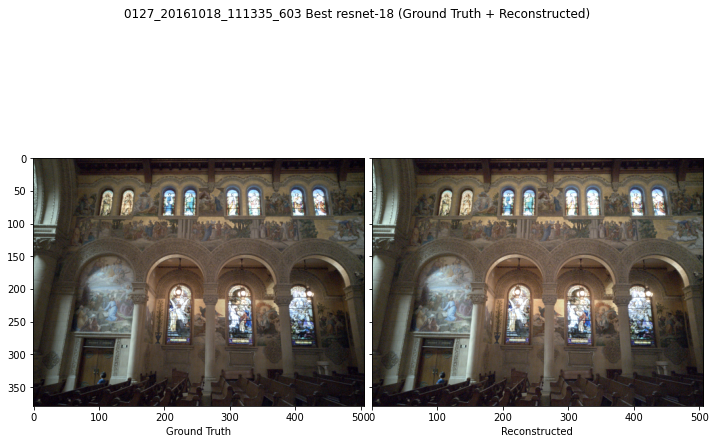

In [15]:
from dhdrnet.vis_util import show_image_pair, show_predictions

show_predictions(predictions, "Best resnet-18", image_names, ev_options)

In [16]:
from more_itertools import chunked, flatten


def load_image(name):
    return Image.open(DATA_DIR / "exposures" / f"{name}[0.0].png")


test_names = [
    str(name_arr[0])
    for name_arr in pd.read_csv(
        ROOT_DIR / "precomputed_data" / "test_current.csv"
    ).to_numpy()
]

In [17]:
from torchvision.transforms import Compose, Resize, ToTensor


def predictions_by_name(img_name, model):
    name_preds = []
    for chunk in chunked(test_names, n=32):
        images = [load_image(im) for im in chunk]

        transform = Compose(
            [
                Resize((300, 300)),
                ToTensor(),
            ]
        )

        test_batch = torch.stack([transform(im) for im in images])
        predictions = get_preds(model, test_batch).numpy()
        name_preds.append(zip(chunk, predictions, (ev_options[p] for p in predictions)))

    name_preds = list(flatten(name_preds))
    return name_preds


df = pd.DataFrame.from_records(
    predictions_by_name(test_names, best_model),
    columns=["name", "pred_ev_index", "pred_ev"],
).set_index("name")
df

pred_ev_index  pred_ev
name                                            
0030_20151008_105249_589             28     4.00
5066_20160724_121618_110              8    -1.00
0037_20160719_125227_729             29     4.25
0543_20150918_175650_498             30     4.50
5a9e_20150404_131348_909             29     4.25
...                                 ...      ...
0543_20150918_072911_757             23     2.75
0043_20160908_100556_696             29     4.25
9bf4_20150824_204210_479             29     4.25
33TJ_20150607_020736_953             27     3.75
0043_20160923_122514_781             26     3.50

[724 rows x 2 columns]

In [18]:
from dhdrnet.dataset import LUTDataset

test_data = LUTDataset(
    df=pd.read_csv(ROOT_DIR / "precomputed_data" / "store_current.csv"),
    exposure_path=DATA_DIR / "correct_exposures" / "exposures",
    raw_dir=DATA_DIR / "dngs",
    name_list=ROOT_DIR / "precomputed_data" / "test_current.csv",
)

In [19]:
test_data.opt_choices

name
0006_20160721_170707_736    3.25
0006_20160721_175239_909    3.75
0006_20160721_181525_062    4.00
0006_20160722_100126_028    3.50
0006_20160722_100951_201    6.00
                            ... 
c483_20150901_173210_443   -0.75
c483_20150901_194029_165    3.75
c483_20150901_195108_436    3.00
c483_20150901_214630_530    3.00
c483_20150901_221141_886    3.50
Length: 724, dtype: float64

In [20]:
df["opt_ev"] = test_data.opt_choices
ev_df = df[["pred_ev", "opt_ev"]].copy()
ev_df

pred_ev  opt_ev
name                                     
0030_20151008_105249_589     4.00    4.25
5066_20160724_121618_110    -1.00   -0.50
0037_20160719_125227_729     4.25    4.50
0543_20150918_175650_498     4.50    4.50
5a9e_20150404_131348_909     4.25    4.50
...                           ...     ...
0543_20150918_072911_757     2.75    2.50
0043_20160908_100556_696     4.25    4.50
9bf4_20150824_204210_479     4.25    4.75
33TJ_20150607_020736_953     3.75    4.00
0043_20160923_122514_781     3.50    2.25

[724 rows x 2 columns]

<AxesSubplot:>

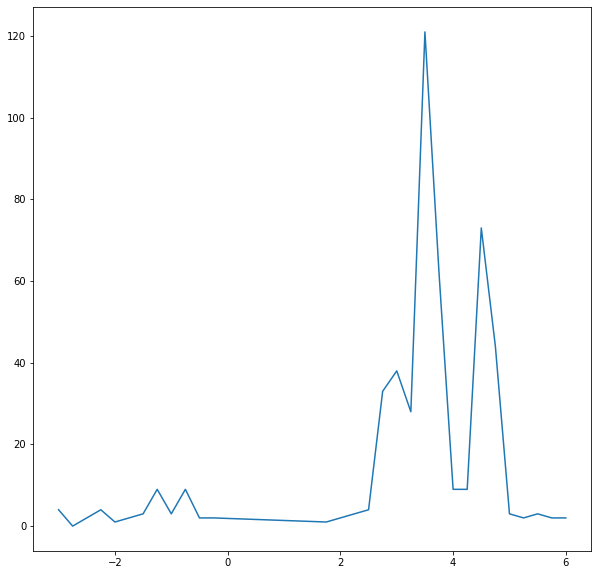

In [21]:
ev_counts = ev_df.apply(lambda s: s.value_counts()).fillna(0).astype(int)
diffs = ((ev_counts["pred_ev"] - ev_counts["opt_ev"]) ** 2).transform(np.sqrt)
diffs.plot()

In [22]:
ev_df["pred_diff"] = abs(ev_df["opt_ev"] - ev_df["pred_ev"])
accuracy = len(ev_df[ev_df["pred_diff"] == 0]) / len(ev_df)
accuracy

0.19889502762430938

In [23]:
ev_df

pred_ev  opt_ev  pred_diff
name                                                
0030_20151008_105249_589     4.00    4.25       0.25
5066_20160724_121618_110    -1.00   -0.50       0.50
0037_20160719_125227_729     4.25    4.50       0.25
0543_20150918_175650_498     4.50    4.50       0.00
5a9e_20150404_131348_909     4.25    4.50       0.25
...                           ...     ...        ...
0543_20150918_072911_757     2.75    2.50       0.25
0043_20160908_100556_696     4.25    4.50       0.25
9bf4_20150824_204210_479     4.25    4.75       0.50
33TJ_20150607_020736_953     3.75    4.00       0.25
0043_20160923_122514_781     3.50    2.25       1.25

[724 rows x 3 columns]

In [24]:
len(ev_df[ev_df["pred_diff"] <= 0.50]) / len(ev_df)

0.8439226519337016

In [25]:
from dhdrnet.util import pred_distance

pred_thresh = pd.DataFrame.from_dict(
    {
        thresh: pred_distance(thresh, ev_df, "opt_ev", "pred_ev")
        for thresh in np.arange(0, 8, 0.25)
    },
    orient="index",
    columns=["Count"],
)
pred_thresh.index = pred_thresh.index.rename("EV Difference")
pred_thresh.to_csv(ROOT_DIR / "figures" / "pct_within.csv")
# pred_thresh.sort_index().plot.barh(title="% within N EV of Optimal", legend=True)
pred_thresh

Count
EV Difference       
0.00             144
0.25             451
0.50             611
0.75             647
1.00             663
1.25             677
1.50             679
1.75             681
2.00             685
2.25             686
2.50             687
2.75             687
3.00             687
3.25             688
3.50             688
3.75             689
4.00             691
4.25             696
4.50             702
4.75             710
5.00             712
5.25             713
5.50             715
5.75             717
6.00             719
6.25             721
6.50             722
6.75             722
7.00             722
7.25             723
7.50             723
7.75             724

In [26]:
print(len(ev_df) - pred_thresh.diff().sum())
# pred_thresh.diff().plot()
new_at_ev = pred_thresh.diff()
new_at_ev.iloc[0] = len(ev_df) - new_at_ev.sum()
new_at_ev = new_at_ev / len(ev_df)
new_at_ev["cumsum"] = new_at_ev.cumsum()
new_at_ev = new_at_ev.rename(columns={"Count": "pct"})
new_at_ev

Count    144.0
dtype: float64


pct    cumsum
EV Difference                    
0.00           0.198895  0.198895
0.25           0.424033  0.622928
0.50           0.220994  0.843923
0.75           0.049724  0.893646
1.00           0.022099  0.915746
1.25           0.019337  0.935083
1.50           0.002762  0.937845
1.75           0.002762  0.940608
2.00           0.005525  0.946133
2.25           0.001381  0.947514
2.50           0.001381  0.948895
2.75           0.000000  0.948895
3.00           0.000000  0.948895
3.25           0.001381  0.950276
3.50           0.000000  0.950276
3.75           0.001381  0.951657
4.00           0.002762  0.954420
4.25           0.006906  0.961326
4.50           0.008287  0.969613
4.75           0.011050  0.980663
5.00           0.002762  0.983425
5.25           0.001381  0.984807
5.50           0.002762  0.987569
5.75           0.002762  0.990331
6.00           0.002762  0.993094
6.25           0.002762  0.995856
6.50           0.001381  0.997238
6.75           0.000000  0.997238
7.00           0.000000  0.997238
7.25           0.001381  0.998619
7.50           0.000000  0.998619
7.75           0.001381  1.000000

0.424033149171


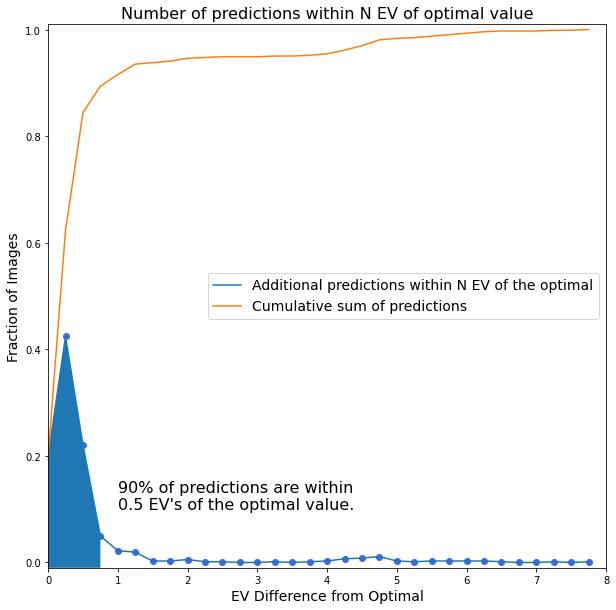

In [27]:
fig, ax = plt.subplots()

plt.xlim(0, 8)
plt.ylim(-0.01, 1.01)
# ax.axhline(y=0,color="black",linestyle="-")

ax.plot(new_at_ev["pct"])
ax.plot(new_at_ev["cumsum"])

ax.set_title("Number of predictions within N EV of optimal value", fontsize=16)
ax.set_xlabel("EV Difference from Optimal", fontsize=14)
ax.set_ylabel("Fraction of Images", fontsize=14)

ax.scatter(new_at_ev.index, new_at_ev["pct"], marker="o", color="royalblue")

thresh = 0.9
ax.fill_between(
    x=new_at_ev.index, y1=-0.01, y2=new_at_ev["pct"], where=new_at_ev["cumsum"] < thresh
)

vline_x = first(new_at_ev[new_at_ev["cumsum"] > thresh - 0.25].index)
# ax.axvline(x=vline_x, linestyle="--", color="black")
ax.text(
    vline_x + 0.5,
    0.1,
    f"{int(thresh*100)}% of predictions are within \n{vline_x} EV's of the optimal value.",
    fontsize=16,
)

ax.legend(
    [
        "Additional predictions within N EV of the optimal",
        "Cumulative sum of predictions",
    ],
    fontsize=14,
    #     loc="center right",
)

plt.savefig(figdir / "pct_pred_thresh_n_ev_best_model.png")
print(new_at_ev["pct"][vline_x - 0.25])

In [ ]:
tdf = test_data.data
tdf

In [ ]:
tdf.xs(("mse"), axis=1)

In [ ]:
udf = pd.read_csv(
    ROOT_DIR / "precomputed_data" / "store_updown_wider-2020-07-27.csv"
).set_index("name")
udf

# next
take the corresponding evs for the predictions, and compare the errors from both for a measure of how much better they are.

Do the same for all ev == 1, all ev == -1, all ev == 4.5 (as it is most likely correct choice by histogram)
And then compare it to randomly selecting an EV.

In [ ]:
ev_df.plot.scatter(x="opt_ev", y="pred_ev", c="pred_diff")

In [ ]:
from collections import defaultdict

opt_mse = defaultdict(dict)
for name in test_data.names:
    opt_ev = ev_df.loc[name, "pred_ev"]
    for metric in ["mse", "perceptual", "ssim"]:
        opt_mse["optimal_ev"][name] = opt_ev
        opt_mse[metric][name] = tdf.loc[name, (metric, opt_ev)]

opt_df = pd.DataFrame.from_dict(opt_mse)
opt_df

In [ ]:
updown_df = udf.groupby(["ev", "metric"]).describe()
updown_df = updown_df.drop(columns="count", level=1)
updown_df.to_excel(ROOT_DIR / "stats" / "updown_stats.xlsx")
updown_df

In [ ]:
flat_test_df = (
    tdf.unstack()
    .reset_index()
    .rename(columns={"level_2": "name", 0: "score"})
    .set_index("name")
)
fixed_choice_stats = (
    flat_test_df.groupby(["ev", "metric"])
    .describe()
    .drop(columns="count", level=1)
    .rename({"score": ""}, level=1)
)
fixed_choice_stats.columns = [c[1] for c in fixed_choice_stats.columns]
fixed_choice_stats.to_excel(ROOT_DIR / "stats" / "fixed_choice_stats.xlsx")
fixed_choice_stats

In [ ]:
td_df = tdf.stack().reset_index().rename(columns={"level_0": "name"}).set_index("name")
td_df["rmse"] = td_df["mse"].transform(np.sqrt)
td_df = td_df.melt(
    value_vars=["mse", "perceptual", "ssim", "rmse"], id_vars=["ev"], ignore_index=False
)
fixed_choice_stats = (
    td_df.groupby(["ev", "metric"]).describe().drop(columns="count", level=1)
)
fixed_choice_stats.columns = [c[1] for c in fixed_choice_stats.columns]
fixed_choice_stats.to_excel(ROOT_DIR / "stats" / "fixed_choice_stats.xlsx")
fixed_choice_stats

In [ ]:
from collections import defaultdict
from pprint import pprint

grouped = td_df.groupby("metric")
gnames = ["mse", "ssim", "perceptual", "rmse"]
pred_evs = []
ei = ev_df.reset_index()
for g, gname in zip([grouped.get_group(gname) for gname in gnames], gnames):
    gi = g.reset_index()
    for row in ei.itertuples():
        pred_ev = row.pred_ev
        val = gi[(gi["name"] == row.name) & (gi["ev"] == pred_ev)]["value"].iloc[0]
        pred_evs.append((row.name, row.pred_ev, gname, val))

In [ ]:
pred_df = pd.DataFrame.from_records(
    pred_evs, columns=["name", "ev", "metric", "value"], index="name"
)
# pred_df = pred_df.pivot(columns=["metric"])
pred_df.groupby(["ev", "metric"]).describe()

In [ ]:
td_df

In [ ]:
fixed_choice_stats.reset_index().groupby("metric").plot.scatter(x="ev", y="mean")

In [ ]:
t_mse = tdf["mse"]
for i in range(1, 5):
    if i < 4:
        opt_df[f"ev{-i}_mse"] = t_mse[-i]
    opt_df[f"ev+{i}_mse"] = t_mse[i]
opt_df

In [ ]:
from pandas.plotting import scatter_matrix

scatter_matrix(opt_df, alpha=0.2, diagonal="kde")

In [ ]:
updown_pct = pd.DataFrame()
for i in range(1, 5):
    #     updown_pct[f"EV -{i} Difference"] =
    #     updown_pct[f"EV +{i} Difference"] =
    if i < 4:
        print(
            f'-{i}:  {opt_df[["mse", f"ev-{i}_mse"]].pct_change(axis="columns").mean().iloc[1]}'
        )
    print(
        f'+{i}: {opt_df[["mse", f"ev+{i}_mse"]].pct_change(axis="columns").mean().iloc[1]}'
    )

# updown_pct

In [ ]:
opt_df[["mse", "ev-1_mse"]].pct_change(axis="columns").mean()

In [ ]:
for i in range(1, 5):
    print(
        i, opt_df[["mse", f"updown_mse_{i}"]].pct_change(axis="columns").mean().iloc[1]
    )

In [ ]:
opt_df.mean()